<a href="https://colab.research.google.com/github/melih84/3D-PointCloud-Classification/blob/main/3d_classification_pointnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D Object Classification in Point Cloud data with PointNet (Qi et al., 2017) using ModelNet10 dataset


In [1]:
pip install trimesh

     |████████████████████████████████| 640 kB 5.4 MB/s 


In [2]:
import os
import glob
import trimesh
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

First, we will download the ModelNet10 dataset

In [3]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473415680/473402300 [==============================] - 7s 0us/step


Let's visualize some example mesh images from the dataset

In [4]:
mesh = trimesh.load(os.path.join(DATA_DIR, "bed/train/bed_0001.off"))
mesh.show()

In [5]:
mesh2 = trimesh.load(os.path.join(DATA_DIR, "table/train/table_0003.off"))
mesh2.show()

Now, we will convert these images to point cloud

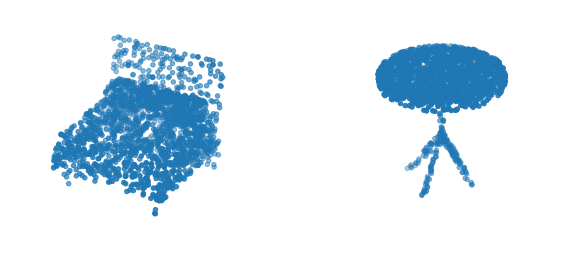

In [6]:
points = mesh.sample(2048) # gets 2048 points from the mesh image randomly
points2 = mesh2.sample(2048)

fig = plt.figure(figsize=(10, 10))

# creates two subplots for each object
axis = fig.add_subplot(221, projection="3d")
axis2 = fig.add_subplot(222, projection="3d")

# scatter points in 3 dimensions
axis.scatter(points[:, 0], points[:, 1], points[:, 2])
axis2.scatter(points2[:, 0], points2[:, 1], points2[:, 2])

# removes axis names
axis.set_axis_off()
axis2.set_axis_off()

plt.show()

Now we will parse the dataset to create tf.data.dataset(). From https://keras.io/examples/vision/pointnet/

In [7]:
# dataset preperation taken from https://keras.io/examples/vision/pointnet/

def prepare_dataset(num_points):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}

    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*")) # for all files other than readme

    for i, folder in enumerate(folders):
        # each object's mesh will be converted to point cloud
        print("Processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for file in train_files:
            train_points.append(trimesh.load(file).sample(num_points))
            train_labels.append(i)

        for file in test_files:
            test_points.append(trimesh.load(file).sample(num_points))
            test_labels.append(i)

    print("All classes are processed!")

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [8]:
num_points = 2048

train_points, test_points, train_labels, test_labels, CLASS_MAP = prepare_dataset(num_points)

Processing class: bathtub
Processing class: dresser
Processing class: monitor
Processing class: table
Processing class: chair
Processing class: toilet
Processing class: sofa
Processing class: bed
Processing class: night_stand
Processing class: desk
All classes are processed!


Let's visualize the shapes of our numpy arrays

In [9]:
print("Shape of train points is ", train_points.shape)
print("Shape of train labels is ", train_labels.shape)
print("Shape of test points is ", test_points.shape)
print("Shape of test labels is ", test_labels.shape)


Shape of train points is  (3991, 2048, 3)
Shape of train labels is  (3991,)
Shape of test points is  (908, 2048, 3)
Shape of test labels is  (908,)


3991 and 908 are number of examples in our traning and test sets. (2048, 3) 
describes 3 dimensional coordinates of 2048 points we sample for each 
object.          

We will use data augmentation to get more training images

In [10]:
def augment(points, label):
    # jitter points
    min_jitter = -0.005
    max_jitter = 0.005
    points += tf.random.uniform(points.shape, min_jitter, max_jitter, dtype=tf.float64)
    
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


Now we will create a tf.data.Dataset from the previous numpy arrays which describe the coordinates of sample points of objects in the point cloud

In [11]:
num_classes = 10
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(batch_size)
test_dataset = test_dataset.shuffle(len(test_points)).batch(batch_size)

# Creating the model components

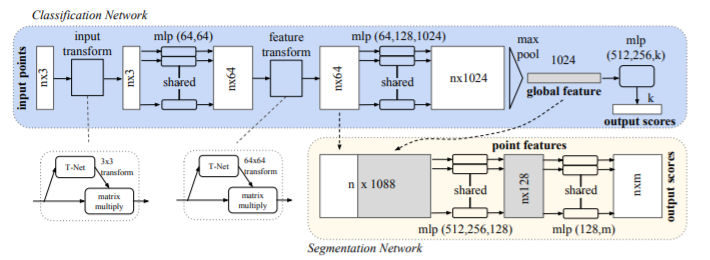

In [12]:
def convolution(x, filters):
    # convolution layer
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    x = layers.Activation("relu")(x)
    return x

def fully_connected(x, filters):
    # fully-connected-layer (dense layer)
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    x = layers.Activation("relu")(x)
    return x


I use the same regularizer given in the PointNet paper

In [13]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg = 0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2,2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

Transformer net described in the paper

In [19]:
def tnet(inputs, num_features):

    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = convolution(inputs, 32)
    x = convolution(x, 64)
    x = convolution(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = fully_connected(x, 256)
    x = fully_connected(x, 128)
    x = layers.Dense(num_features**2,
                     kernel_initializer='zeros',
                     bias_initializer=bias,
                     activity_regularizer=reg)(x)

    feat_T = layers.Reshape((num_features, num_features))(x)

    return layers.Dot(axes=(2,1))([inputs, feat_T])

In [20]:
num_points = 2048
inputs = keras.Input(shape=(num_points,3))

x = tnet(inputs, 3)
x = convolution(x, 32)
x = convolution(x, 32)
x = tnet(x, 32)
x = convolution(x, 32)
x = convolution(x, 64)
x = convolution(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = fully_connected(x, 256)
x = layers.Dropout(0.3)(x)
x = fully_connected(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs = outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 2048, 32)     128         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 2048, 32)    128         ['conv1d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 2048, 32)     0           ['batch_normalization_17[0]

In [21]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=18, validation_data=test_dataset)

Epoch 1/18
125/125 [==============================] - 51s 354ms/step - loss: 3.5557 - sparse_categorical_accuracy: 0.2834 - val_loss: 10490282110936416256.0000 - val_sparse_categorical_accuracy: 0.3711
Epoch 2/18
125/125 [==============================] - 43s 347ms/step - loss: 3.0408 - sparse_categorical_accuracy: 0.3789 - val_loss: 985672714289152.0000 - val_sparse_categorical_accuracy: 0.3238
Epoch 3/18
125/125 [==============================] - 43s 346ms/step - loss: 2.7353 - sparse_categorical_accuracy: 0.4848 - val_loss: 580292858189478625280.0000 - val_sparse_categorical_accuracy: 0.4053
Epoch 4/18
125/125 [==============================] - 43s 347ms/step - loss: 2.5561 - sparse_categorical_accuracy: 0.5575 - val_loss: 90.7405 - val_sparse_categorical_accuracy: 0.3392
Epoch 5/18
125/125 [==============================] - 43s 346ms/step - loss: 2.3958 - sparse_categorical_accuracy: 0.6041 - val_loss: 865145984.0000 - val_sparse_categorical_accuracy: 0.3106
Epoch 6/18
125/125 [===

we managed to get a 0.77 validation set accuracy

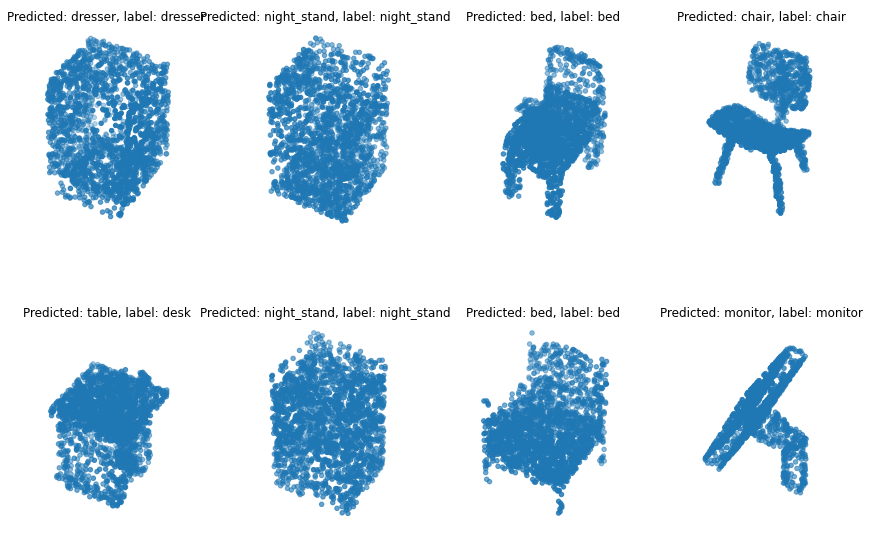

In [24]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "Predicted: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()